In [6]:
import os
import cv2 
import rasterio

from matplotlib import pyplot as plt 


In [23]:
impaths = sorted([f"images/{f}" for f in os.listdir("images") if ".jpeg" in f and "_T34VEJ_" in f], key=lambda k: k.split("_")[6])

In [24]:
impaths

['images/Sentinel2_S2A_MSIL2A_20230609T100031_N0509_R122_T34VEJ_20230609T132603.SAFE_true_color_base.jpeg',
 'images/Sentinel2_S2B_MSIL2A_20230608T093549_N0509_R036_T34VEJ_20230608T112304.SAFE_true_color_base.jpeg']

In [25]:
images = [cv2.cvtColor(cv2.imread(i), cv2.COLOR_BGR2RGB) for i in impaths]


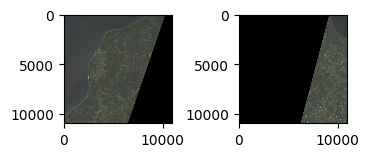

In [26]:
ct = 1
for i in images:
    plt.subplot(3, 3, ct)
    plt.imshow(i)  
    ct += 1

plt.show()


In [31]:
# B04 and B08 for calculating NDVI => ((B08-B04)/(B08+B04))
# NDVI > 7 indicates presence of forest
#
# SCL for working out if what we're seeing is a cloud
# discard if SCL includes ones of invalid = [
#     0, // NO_DATA
#     1, // SATURATED_DEFECTIVE
#     3, // CLOUD_SHADOW
#     7, // CLOUD_LOW_PROBA
#     8, // CLOUD_MEDIUM_PROBA
#     9, // CLOUD_HIGH_PROBA
#     10 // THIN_CIRRUS
# ]

In [27]:
# T34VEJ_20230608T093549_SCL_20m
# T34VEJ_20230609T100031_SCL_20m
# T34VEJ_20230611T094549_SCL_20m

In [28]:
scl = rasterio.open("data/T34VEJ_20230608T093549_SCL_20m.jp2", driver="JP2OpenJPEG").read(1)

In [29]:
scl

array([[0, 0, 0, ..., 6, 6, 6],
       [0, 0, 0, ..., 6, 6, 6],
       [0, 0, 0, ..., 6, 6, 6],
       ...,
       [0, 0, 0, ..., 4, 4, 4],
       [0, 0, 0, ..., 4, 4, 4],
       [0, 0, 0, ..., 4, 4, 4]], shape=(5490, 5490), dtype=uint8)

In [30]:
list(set([f.split("_")[6] for f in os.listdir("images") if ".jpeg" in f]))

['T35VNC',
 'T35ULB',
 'T34UEG',
 'T34VDH',
 'T34VFK',
 'T34UDG',
 'T35VLE',
 'T34VEJ',
 'T35VME',
 'T35VMD',
 'T34VFJ',
 'T34VEH',
 'T35VLD',
 'T34VEK',
 'T34VDK',
 'T35VNE']

In [32]:
# -32768 NODATA

In [33]:
#function getFirstQuartileValue(values) {
#    values.sort((a,b) => a-b);
#    return getFirstQuartile(values);
#}
#
#function getFirstQuartile(sortedValues) {
#    var index = Math.floor(sortedValues.length / 4);
#    return sortedValues[index];
#}

In [36]:
paths = [f"data/{f}" for f in os.listdir("data") if ".jp2" in f and "T34VEJ_" in f]
reds = [f"data/{f}" for f in os.listdir("data") if ".jp2" in f and "T34VEJ_" in f and "_B04_" in f]
greens = [f"data/{f}" for f in os.listdir("data") if ".jp2" in f and "T34VEJ_" in f and "_B03_" in f]
blues = [f"data/{f}" for f in os.listdir("data") if ".jp2" in f and "T34VEJ_" in f and "_B02_" in f]
beights = [f"data/{f}" for f in os.listdir("data") if ".jp2" in f and "T34VEJ_" in f and "_B08_" in f]
covs = [f"data/{f}" for f in os.listdir("data") if ".jp2" in f and "T34VEJ_" in f and "_SCL_" in f]


In [35]:
paths

['data/T34VEJ_20230609T100031_B04_10m.jp2',
 'data/T34VEJ_20230608T093549_B08_10m.jp2',
 'data/T34VEJ_20230608T093549_B03_10m.jp2',
 'data/T34VEJ_20230611T094549_B04_10m.jp2',
 'data/T34VEJ_20230608T093549_SCL_20m.jp2',
 'data/T34VEJ_20230608T093549_B02_10m.jp2',
 'data/T34VEJ_20230611T094549_B08_10m.jp2',
 'data/T34VEJ_20230609T100031_SCL_20m.jp2',
 'data/T34VEJ_20230609T100031_B02_10m.jp2',
 'data/T34VEJ_20230609T100031_B03_10m.jp2',
 'data/T34VEJ_20230611T094549_B02_10m.jp2',
 'data/T34VEJ_20230611T094549_SCL_20m.jp2',
 'data/T34VEJ_20230608T093549_B04_10m.jp2',
 'data/T34VEJ_20230609T100031_B08_10m.jp2',
 'data/T34VEJ_20230611T094549_B03_10m.jp2']

In [37]:
reds

['data/T34VEJ_20230609T100031_B04_10m.jp2',
 'data/T34VEJ_20230611T094549_B04_10m.jp2',
 'data/T34VEJ_20230608T093549_B04_10m.jp2']

In [38]:
greens

['data/T34VEJ_20230608T093549_B03_10m.jp2',
 'data/T34VEJ_20230609T100031_B03_10m.jp2',
 'data/T34VEJ_20230611T094549_B03_10m.jp2']

In [39]:
blues

['data/T34VEJ_20230608T093549_B02_10m.jp2',
 'data/T34VEJ_20230609T100031_B02_10m.jp2',
 'data/T34VEJ_20230611T094549_B02_10m.jp2']

In [40]:
beights

['data/T34VEJ_20230608T093549_B08_10m.jp2',
 'data/T34VEJ_20230611T094549_B08_10m.jp2',
 'data/T34VEJ_20230609T100031_B08_10m.jp2']

In [41]:
covs

['data/T34VEJ_20230608T093549_SCL_20m.jp2',
 'data/T34VEJ_20230609T100031_SCL_20m.jp2',
 'data/T34VEJ_20230611T094549_SCL_20m.jp2']